In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [2]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, walltime='04:00:00')
w = cluster.scale(6*30)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [18]:
client

Client Scheduler: tcp://10.135.39.28:33273 Dashboard: http://10.135.39.28:8787/status,Cluster Workers: 180 Cores: 1080 Memory: 1.50 TB


#### spectra of (part 1) ageo. (part 2) geo. (part 3) total KE. 
#### comparison in part 4

___________
## Term 1: time acceleration

### du/dt and dv/dt

In [6]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/daily/'

grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd])

In [12]:
dij = 4
time_length = 1440*3

dsU = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSU')).isel(time=slice(200,200+time_length)) #8584
dsV = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSV')).isel(time=slice(200,200+time_length))

ds_raw = (xr.merge([dsU,dsV]).assign_coords(**grd.variables))
#grid = xgcm.Grid(ds_raw, periodic=['X', 'Y'])
print(ds_raw)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 4584)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<chunksize=(4584,), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) float64 6.422e+06 6.426e+06 6.43e+06 ... 2.292e+07 2.292e+07
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHr

In [13]:
# parameters for rechunking: time and space
Nt, Ni, Nj = 0, 188, 96
dij=4

In [ ]:
# spatial strides for decimation
dij=8
overwrite=True
    
#for face in range(13):
for face in [1]:

    Efile = work_data_dir+'xy/momentum_balance/hourly/E_duv_dt_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        d_SSU_dt_time = ( ds_raw['SSU'].isel(face=face,i_g=slice(0,None,dij), j=slice(0,None,dij)).shift(time=-1) - ds_raw['SSU'].isel(face=face,i_g=slice(0,None,dij), j=slice(0,None,dij)).shift(time=1) )/2/3600
        d_SSV_dt_time = ( ds_raw['SSV'].isel(face=face,i=slice(0,None,dij), j_g=slice(0,None,dij)).shift(time=-1) - ds_raw['SSV'].isel(face=face,i=slice(0,None,dij), j_g=slice(0,None,dij)).shift(time=1) )/2/3600
        
        
        ds = xr.merge([d_SSU_dt_time.rename({'i_g': 'i'}), d_SSV_dt_time.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))
        
        # generate a complex vector variable
        ds['uv_ageo'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)    

        # should show the size of the dataset to know if we can load it in memory
        print(ds)
        print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency line
        f, E = get_E(ds['uv_ageo'].isel(i=2,j=2))
        #
        E = get_E(ds['uv_ageo'], f=f)        

        # store
        E = E.to_dataset()
        print(E)
        for c in E.coords:
            try:
                del E[c].encoding['chunks']
            except:
                print(c)        
        E = E.chunk({'i': 24*8, 'j':47*4})
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

<xarray.DataArray 'SSU' (time: 4584, j: 540, i_g: 540)>
dask.array<truediv, shape=(4584, 540, 540), dtype=float32, chunksize=(1, 540, 540), chunktype=numpy.ndarray>
Coordinates:
    dtime    (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-06-01T07:00:00
    face     int64 1
  * i_g      (i_g) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
    iters    (time) int64 256896 257040 257184 257328 ... 916560 916704 916848
  * j        (j) int64 0 8 16 24 32 40 48 ... 4264 4272 4280 4288 4296 4304 4312
  * time     (time) float64 6.422e+06 6.426e+06 6.43e+06 ... 2.292e+07 2.292e+07
    dxC      (j, i_g) float32 1261.4568 1261.4568 ... 2251.2761 2251.2761
    dyG      (j, i_g) float32 1230.9597 1230.9597 ... 2073.8413 2073.8413
    hFacW    (j, i_g) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    rAw      (j, i_g) float32 1552802.6 1552802.6 ... 4668789.0 4668789.0
<xarray.Dataset>
Dimensions:  (i: 540, i_g: 4320, j: 540, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90,

In [15]:
print(E)

<xarray.Dataset>
Dimensions:    (freq_time: 1440, i: 1080, j: 1080)
Coordinates:
    face       int64 1
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    CS         (j, i) float32 dask.array<chunksize=(188, 192), meta=np.ndarray>
    Depth      (j, i) float32 dask.array<chunksize=(188, 192), meta=np.ndarray>
    SN         (j, i) float32 dask.array<chunksize=(188, 192), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(188, 192), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(188, 192), meta=np.ndarray>
    hFacC      (j, i) float32 dask.array<chunksize=(188, 192), meta=np.ndarray>
    mask       (j, i) bool dask.array<chunksize=(188, 192), meta=np.ndarray>
    rA         (j, i) float32 dask.array<chunksize=(188, 192), meta=np.ndarray>
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
Data variables:
    uv_ageo 

## 2. band-integral results (KE)
### band integral of spectra

In [43]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


for face in face_all:
    
    ds = xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_ageo_uv_f%02d.zarr'%(face))
    chunks={'i': 188, 'j':192, 'freq_time':1440}
    ds = ds.chunk(chunks)     
    E = ds.uv_ageo
    #E = E.assign_coords(freq_cps=E.freq_time / 86400.) 
    df=E.freq_time[1]-E.freq_time[0]

    # total KE
    E_all = (E*df).sum(dim='freq_time')
    E_all = E_all.chunk({'i': 1080, 'j': 1080}) 
    E_all = np.real(E_all).rename('E_all')

    # high-frequency KE (<0.5 day)
    E_high = (E.where(abs(E.freq_time)>0.5, other=0.)*df).sum(dim='freq_time')
    E_high = E_high.chunk({'i': 1080, 'j': 1080}) 
    E_high = np.real(E_high).rename('E_high')

    # semi-diurnal
    E_semi = (E.where((abs(E.freq_time)>1.9) & (abs(E.freq_time)<2.1), other=0.)*df).sum(dim='freq_time')
    E_semi = E_semi.chunk({'i': 1080, 'j': 1080}) 
    E_semi = np.real(E_semi).rename('E_semi')

    # diurnal
    E_diurnal = (E.where((abs(E.freq_time)>0.9) & (abs(E.freq_time)<1.1), other=0.)*df).sum(dim='freq_time')
    E_diurnal = E_diurnal.chunk({'i': 1080, 'j': 1080}) 
    E_diurnal = np.real(E_diurnal).rename('E_diurnal')
    
    # near-inertial
    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
    f_cpd_llc = f_llc*86400/2./np.pi
    E_f = (E.where((abs(E.freq_time+f_cpd_llc)<0.1), other=0.)*df).sum(dim='freq_time')
    E_f = np.real(E_f).rename('E_f')

    # low-frequency KE (>0.5 day)    
    E_low = E_all - E_high
    E_low = E_low.chunk({'i': 1080, 'j': 1080}) 
    E_low = np.real(E_low).rename('E_low')

    # merge together
    E_band = xr.merge([E_high, E_semi, E_diurnal, E_f, E_all, E_low])
    
    file_E = work_data_dir+'xy/Ageo_uv/E_band_integral_f%02d.zarr'%face
    E_band.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

face 11 done


In [19]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_all = xr.concat(D, dim='face')
print(ds_all)

<xarray.Dataset>
Dimensions:    (face: 13, i: 1080, j: 1080)
Coordinates:
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_j        (face, j, i) float32 dask.arr

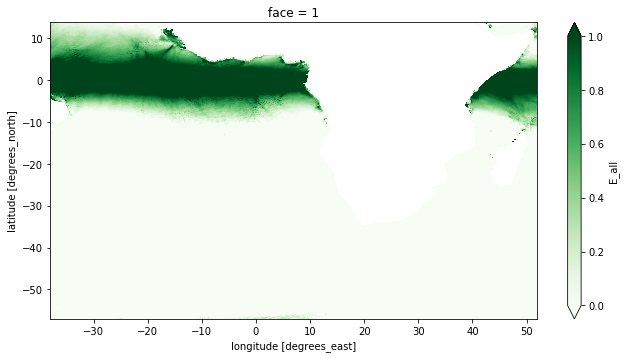

In [21]:
fig = plt.figure(figsize = (24,12))

plt.subplot(221)
np.log10(ds_all['E_all'].isel(face=1)).plot(x='XC', y='YC',vmin=0.,vmax=1.,cmap = 'Greens')


## 3. zonal average of rotary spectra

In [30]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
ice

<xarray.DataArray 'AREA' (face: 13, j: 1080, i: 1080)>
dask.array<getitem, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

In [29]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [33]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_ageo_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksiz

In [34]:
v = 'uv_ageo'
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
F = [11]

In [36]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    lice = ice.isel(face=face)
    #E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False) # filter out shallow depths
    E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False).where(lice>0) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/Ageo_uv/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done
--- face 2 done
--- face 3 done
--- face 4 done
--- face 5 done
--- face 6 done
--- face 7 done
--- face 8 done
--- face 9 done
--- face 10 done
--- face 12 done


In [37]:
F = [11]

for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    lice = ice.isel(face=face)
    E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False).where(lice>0)  # filter out shallow depths
    #E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/Ageo_uv/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 11 done


In [38]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
print(ds_zav)

<xarray.Dataset>
Dimensions:    (freq_time: 1440, latitude: 119)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    S_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>
    W_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>


In [39]:
E_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [ ]:
plt.figure(figsize=(24,12))
ax = plt.subplot(1,1,1)

np.log10(E_zav).plot(vmin=-4, vmax=2, x='freq_time', y='latitude', cmap='RdBu_r')
ax.set_xticks(list(ax.get_xticks()) + [-12.,-11.,-10.,-9.,-8.,-7.,-6.,-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.,6.,7.,8.,9.,10.,11.,12.])
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)

In [22]:
cluster.close()